In [41]:
import pandas as pd
import nltk
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

In [42]:
# /teamspace/studios/this_studio/sentiment_analysis-project
train_data = './sentiment_analysis-project/data/train.csv'
test_data = './sentiment_analysis-project/data/test.csv'
valid_data = './sentiment_analysis-project/data/validation.csv'

file = './sentiment_analysis-project/multiclass_dataset.csv'

def save_load_df(file:str):
    if os.path.exists(file):
        df = pd.read_csv(file, index_col= 0)
    else:
        df = pd.concat(map(pd.read_csv, [train_data, test_data, valid_data]), axis= 0, ignore_index=True)
        df.to_csv(file, columns= ['id', 'text', 'label', 'sentiment'])
        df = pd.read_csv(file, index_col= 0)
    return df

df = save_load_df(file=file)
df

,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative
...,...,...,...,...
41639,10277,Fuck no internet damn time warner!,0,negative
41640,8610,Looking forward to android 1.5 being pushed t...,1,neutral
41641,8114,Not good. Wasted time.,0,negative
41642,3034,"U were great, as always. But, can`t we do an ...",2,positive


## TP1, TP2

In [43]:
class PreProcess():
    def __init__(self):
        self.text_pattern = re.compile(
        r'(<.+?>)'         # Balises HTML
        r'(#|@)\w+'  # @ and # words
        r'|([a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,})'  # Emails
        r'|(https?://[^\s\n\r]+)' # URLs commençant par http ou https
        r'|(www\.[^\s]+)'      # URLs commençant par www
        r'|([\U00010000-\U0010ffff])'  # Émojis et autres caractères au-delà de l'ASCII étendu
        r'|([^\x00-\xFF])'     # Tout ce qui n'est pas en ASCII étendu (0-255)
        )
        self.emoji_pattern = re.compile(
            "[\U0001F600-\U0001F64F"  # Emoticons
            "\U0001F300-\U0001F5FF"  # Miscellaneous Symbols and Pictographs
            "\U0001F680-\U0001F6FF"  # Transport and Map Symbols
            "\U0001F700-\U0001F77F"  # Alchemical Symbols
            "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
            "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
            "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            "\U0001FA00-\U0001FA6F"  # Chess Symbols
            "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            "\U00002702-\U000027B0"  # Dingbats
            "\U000024C2-\U0001F251"  # Enclosed characters
            "]+",
            flags=re.UNICODE,
        )
        self.punctuation = set(string.punctuation)
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        text = self.text_pattern.sub('', str(text))
        text = self.emoji_pattern.sub('', str(text))
        text = text.lower()
        return text
    
    def get_tokens(self, text):
        text = self.clean_text(text)
        sentences = nltk.sent_tokenize(text)
        tokens = []
        for sentence in sentences:
            words = nltk.word_tokenize(sentence)
            for word in words:
                if word not in self.stop_words:
                    # clean all the punctuation and the StopWords
                    word = ''.join([c for c in word if c not in self.punctuation])
                    if word == '':
                        continue
                    tokens.append(word)
        return tokens

    def lemmetize_with_pos(self, tokens):
        pos_tags = nltk.pos_tag(tokens)
        lemmes = [] 
        pos_tag = []
        for token, pos in pos_tags:
            if pos.startswith('J'):
                lemma = self.lemmatizer.lemmatize(token, pos = 'a')
            elif pos.startswith('V'):
                lemma =  self.lemmatizer.lemmatize(token, pos = 'v')
            elif pos.startswith('RB'):
                lemma = self.lemmatizer.lemmatize(token, pos = 'r')
            elif pos.startswith('N'):
                lemma = self.lemmatizer.lemmatize(token, pos = 'n')
            else:
                lemma = self.lemmatizer.lemmatize(token)
            lemmes.append(lemma)
            pos_tag.append(pos)
        return lemmes, pos_tag
    
    def get_lemmes(self, text):
        tokens = self.get_tokens(text)
        lemmes, _ = self.lemmetize_with_pos(tokens)
        return lemmes
    
    def visualize_data(self, text):
        text = self.clean_text(text)
        tokens = self.get_tokens(text)
        lemmes, pos_tag = self.lemmetize_with_pos(tokens)
        data = [[token, lemme, pos] for token, lemme, pos in zip(tokens, lemmes, pos_tag)]
        return data
    
texts = list(df['text'])
labels = list(df['label'])
process_text = PreProcess()
corpus = pd.DataFrame(data = [(process_text.get_tokens(text), label) for text, label in zip(texts, labels)], columns=['sentence', 'label'])
corpus

,sentence,label
0,"[cooking, microwave, pizzas, yummy]",2
1,"[plans, allowing, sub, tasks, show, widget]",1
2,"[love, humor, reworded, like, saying, group, t...",2
3,"[naw, idk, ur, talkin]",1
4,"[sucks, hear, hate, days, like]",0
...,...,...
41639,"[fuck, internet, damn, time, warner]",0
41640,"[looking, forward, android, 15, pushed, g1]",1
41641,"[good, wasted, time]",0
41642,"[u, great, always, east, germany, noko, least,...",2


In [44]:
# drop the empty rows
corpus = corpus[corpus['sentence'].str.len() != 0]
corpus = corpus.reset_index(drop = True)
corpus

,sentence,label
0,"[cooking, microwave, pizzas, yummy]",2
1,"[plans, allowing, sub, tasks, show, widget]",1
2,"[love, humor, reworded, like, saying, group, t...",2
3,"[naw, idk, ur, talkin]",1
4,"[sucks, hear, hate, days, like]",0
...,...,...
41502,"[fuck, internet, damn, time, warner]",0
41503,"[looking, forward, android, 15, pushed, g1]",1
41504,"[good, wasted, time]",0
41505,"[u, great, always, east, germany, noko, least,...",2


In [45]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_name = 'distilbert-base-uncased'
# model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)
bert_model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [46]:
sentences = list(corpus['sentence'])
sentences = [' '.join(sentence) for sentence in sentences]
X = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

labels = list(corpus['label'])
Y = torch.tensor(labels, dtype = torch.long)

### option 1

In [47]:
# x = {k: v.to(device) for k, v in X.items()}
# with torch.no_grad():
#     x = bert_model(**x)
#     x = x.last_hidden_state
        

### Option 2

In [48]:
X['labels'] = Y
train_data, valid_data, test_data = {}, {}, {}
for k, v in X.items():
    train_data[k], test_data[k] = train_test_split(v, test_size=0.3, train_size=0.7, random_state=42, shuffle=True)
    test_data[k], valid_data[k] = train_test_split(test_data[k], test_size=0.5, train_size=0.5, random_state=42, shuffle=True)

class DictDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['input_ids'])

    def __getitem__(self, idx):
        return {
            'input_ids': self.data['input_ids'][idx],
            'attention_mask': self.data['attention_mask'][idx],
            # 'token_type_ids': self.data['token_type_ids'][idx]
              }, self.data['labels'][idx]



In [49]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

train_data = DictDataset(train_data)
valid_data = DictDataset(valid_data)
test_data = DictDataset(test_data)

batch_size = 256
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)


class LSTModel(nn.Module):
    def __init__(self,
                 embed_dim = 768,
                 hidden_size = 128,
                 bidirectional = False,
                 num_layers = 1,
                 dropout = 0.4
        ):
        super(LSTModel, self).__init__()
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size= embed_dim,
                            hidden_size = hidden_size,
                            num_layers=num_layers,
                            bias= False,
                            bidirectional=bidirectional,
                            batch_first=True,
                            dropout=dropout if num_layers > 1 else 0
        )
        self.D = 1 if self.bidirectional == False else 2
        self.fc2 = nn.Linear(self.D * hidden_size, 3)

    def forward(self, x):
        B, T, C = x.shape
        h0 = torch.zeros((self.D, self.num_layers, B, self.hidden_size), device=device).view(-1, B, self.hidden_size)
        c0 = torch.zeros((self.D, self.num_layers, B, self.hidden_size), device=device).view(-1, B, self.hidden_size)
        out, (h1, c1) = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = F.softmax(self.fc2(out), dim = -1)
        return out

# class LSTModel(nn.Module):
#     def __init__(self,
#                  embed_dim = 768,
#                  hidden_size = 128,
#                  bidirectional = False,
#                  num_layers = 2,
#                  dropout = 0.2
#         ):
#         super(LSTModel, self).__init__()
#         self.bidirectional = bidirectional
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size= embed_dim,
#                             hidden_size = hidden_size,
#                             num_layers=num_layers,
#                             bias= False,
#                             bidirectional=bidirectional,
#                             batch_first=True,
#                             dropout=dropout
#         )
#         self.D = 1 if self.bidirectional == False else 2
#         self.fc1 = nn.Linear(self.D * hidden_size, 2 * self.D * hidden_size)
#         self.dropout = nn.Dropout(dropout)
#         self.bn1 = nn.BatchNorm1d(2 * self.D * hidden_size)
#         self.fc2 = nn.Linear(2 * self.D * hidden_size, 3)

#     def forward(self, x):
#         B, T, C = x.shape
#         h0 = torch.zeros((self.D, self.num_layers, B, self.hidden_size), device=device).view(-1, B, self.hidden_size)
#         c0 = torch.zeros((self.D, self.num_layers, B, self.hidden_size), device=device).view(-1, B, self.hidden_size)
#         out, (h1, c1) = self.lstm(x, (h0, c0))
#         out = out[:, -1, :]
#         out = F.relu(self.fc1(out))
#         out = self.bn1(out)
#         out = self.dropout(out)
#         out = F.softmax(self.fc2(out), dim = -1)
#         return out

torch.manual_seed(42) # for the distribution of the gradient

torch.set_float32_matmul_precision('high')

model = LSTModel()
model.to(device=device)

optimizer = optim.Adam(model.parameters(), lr = 3e-4)


In [50]:
import time

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
num_iter = 100
for i in range(num_iter):
    t1 = time.time()
    train_loss = 0
    train_acc = 0
    model.train()
    for xb_train, yb_train in train_dl:
        x = {k: v.to(device) for k, v in xb_train.items()}
        y = yb_train.to(device)
        
        with torch.no_grad():
            with torch.autocast(device_type = 'cuda', dtype = torch.bfloat16):
                x = bert_model(**x)
                x = x.last_hidden_state
        
        optimizer.zero_grad()
        with torch.autocast(device_type = 'cuda', dtype = torch.bfloat16):
            logits = model(x)
            loss = F.cross_entropy(logits, y)
        loss.backward()
        train_loss += loss.item() * batch_size
        pred = torch.argmax(logits, dim = 1)
        train_acc += (pred == y).float().sum().item()
        optimizer.step()
    train_loss /= len(train_dl.dataset)
    train_acc /= len(train_dl.dataset)
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_acc = 0
        for xb_valid, yb_valid in valid_dl:
            xb_valid = {k: v.to(device) for k, v in xb_valid.items()}
            yb_valid = yb_valid.to(device)
            xb_valid = bert_model(**xb_valid)
            xb_valid = xb_valid.last_hidden_state
            logits = model(xb_valid)
            loss = F.cross_entropy(logits, yb_valid)
            valid_loss += loss.item() * batch_size
            pred = torch.argmax(logits, dim = 1)
            valid_acc += (pred == yb_valid).float().sum().item()
    valid_loss /= len(valid_dl.dataset)
    valid_acc /= len(valid_dl.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)
    t2 = time.time()
    dt = (t2 - t1)
    print(f'epoch {i} || train_loss {train_loss:4f}, valid_loss {valid_loss:4f}, train_accu {train_acc:4f} , valid_accu {valid_acc:4f} , time {dt:4f}')

epoch 0 || train_loss 0.995392, valid_loss 0.936528, train_accu 0.523301 , valid_accu 0.577967 , time 10.561548
epoch 1 || train_loss 0.924665, valid_loss 0.910306, train_accu 0.605011 , valid_accu 0.607837 , time 10.291420
epoch 2 || train_loss 0.916168, valid_loss 0.919495, train_accu 0.612756 , valid_accu 0.590493 , time 10.336272
epoch 3 || train_loss 0.904006, valid_loss 0.902433, train_accu 0.626489 , valid_accu 0.610888 , time 10.284759
epoch 4 || train_loss 0.893108, valid_loss 0.897213, train_accu 0.636780 , valid_accu 0.616669 , time 10.397704
epoch 5 || train_loss 0.900849, valid_loss 0.924923, train_accu 0.628829 , valid_accu 0.587763 , time 10.433612
epoch 6 || train_loss 0.894998, valid_loss 0.919264, train_accu 0.638363 , valid_accu 0.591135 , time 10.515539
epoch 7 || train_loss 0.890998, valid_loss 0.909812, train_accu 0.639051 , valid_accu 0.598362 , time 10.607286
epoch 8 || train_loss 0.888053, valid_loss 0.898851, train_accu 0.642837 , valid_accu 0.617954 , time 10

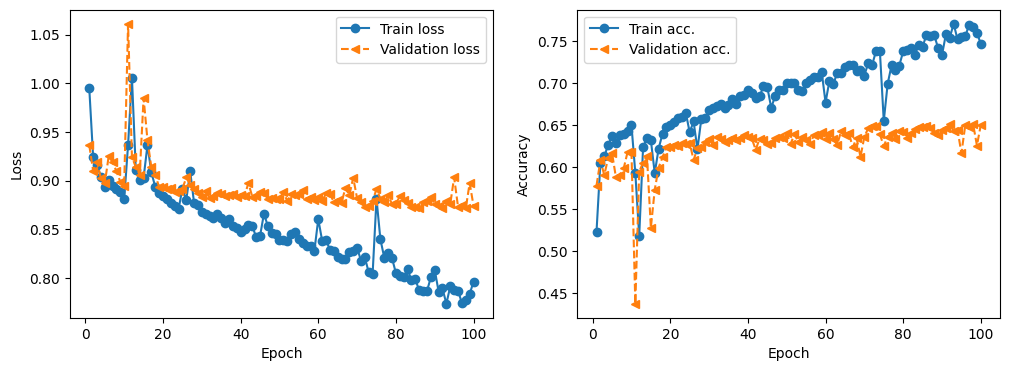

In [51]:
import matplotlib.pyplot as plt

x_arr = np.arange(num_iter) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, train_losses, '-o', label='Train loss')
ax.plot(x_arr, valid_losses, '--<', label='Validation loss')
ax.legend(fontsize=10)
ax.set_xlabel('Epoch', size=10)
ax.set_ylabel('Loss', size=10)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, train_accuracies, '-o', label='Train acc.')
ax.plot(x_arr, valid_accuracies, '--<', label='Validation acc.')
ax.legend(fontsize=10)
ax.set_xlabel('Epoch', size=10)
ax.set_ylabel('Accuracy', size=10)

plt.show()

In [54]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
test_acc = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for xb_test, yb_test in test_dl:
        xb_test = {k: v.to(device) for k, v in xb_test.items()}
        yb_test = yb_test.to(device)

        xb_test = bert_model(**xb_test)
        xb_test = xb_test.last_hidden_state
        logits = model(xb_test)
        pred = torch.argmax(logits, dim = 1)
        test_acc += (pred == yb_test).float().sum().item()
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(yb_test.cpu().numpy())

test_acc /= len(test_dl.dataset)
precision = precision_score(all_labels, all_preds, average='weighted')  # 'weighted' pour pondérer selon les classes
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print('test accuracy', test_acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

test accuracy 0.6635078702216511
Precision: 0.6674288937873121
Recall: 0.6635078702216511
F1-Score: 0.6640640620473636

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.62      0.65      1839
           1       0.60      0.67      0.64      2354
           2       0.72      0.70      0.71      2033

    accuracy                           0.66      6226
   macro avg       0.67      0.66      0.67      6226
weighted avg       0.67      0.66      0.66      6226

